In [1]:
import tensorflow as tf

import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

In [2]:
def hot_encoding_from_category(val, number_of_categories=4):
    """
    Función para hacer la codificación one-hot de la categoría 
    de la imagen
    """
    ans = np.zeros((number_of_categories))
    ans[val] = 1
    return ans

In [3]:
def list_files_in_directory(directory_name):
    """
    Crea una lista con las rutas de todos los archivos dentro de un
    directorio.
    """
    
    return glob.glob(directory_name + "/*")

In [4]:
def get_labels_from_path(file_path):
    """
    Crea un arreglo de numpy con las categoría de
    cada imagen según la carpeta en la que se encuentra.
    Utiliza el one-hot encoding para representar
    las categorías, esto es:
    
    ``[1, 0, 0, 0]``, la imagen es de la categoría *desks*
    ``[0, 1, 0, 0]``, la imagen es de la categoría *exit*
    ``[0, 0, 1, 0]``, la imagen es de la categoría *office*
    ``[0, 0, 0, 1]``, la imagen es de la categoría *soccer_court*
    
    """
    
    labels_he = []
    for x in file_path:
        val = 0
        if x.strip().split('/')[2] == 'desks':
            val = 0
        if x.strip().split('/')[2] == 'exit':
            val = 1
        if x.strip().split('/')[2] == 'office':
            val = 2
        if x.strip().split('/')[2] == 'soccer_court':
            val = 3
        labels_he.append(hot_encoding_from_category(val))
    return np.array(labels_he)

In [5]:
# Inicializa conjunto de entrenamiento
training_paths = np.array(list_files_in_directory('dataset/training_set/*'))
np.random.shuffle(training_paths)
labels_training_set = get_labels_from_path(training_paths)
print(labels_training_set)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [6]:
# Inicializa conjunto de prueba
testing_paths = np.array(list_files_in_directory('dataset/test_set/*'))
np.random.shuffle(testing_paths)
labels_test_set = get_labels_from_path(testing_paths)
print(labels_test_set)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [44]:
training_images = np.array([cv2.cvtColor(cv2.resize(cv2.imread(file_name), (32, 32)), cv2.COLOR_BGR2RGB) / 255 for file_name in training_paths])
testing_images = np.array([cv2.cvtColor(cv2.resize(cv2.imread(file_name), (32, 32)), cv2.COLOR_BGR2RGB) / 255 for file_name in testing_paths])

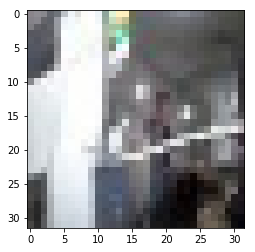

In [45]:
plt.imshow(training_images[2])

In [46]:
print(training_images.shape)
print(training_images.nbytes)
print(testing_images.shape)
print(testing_images.nbytes)

(6000, 32, 32, 3)
147456000
(2112, 32, 32, 3)
51904512


# Creación del modelo

In [47]:
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name="input_x")
y_true = tf.placeholder(tf.float32, shape=[None, 4])

In [48]:
hold_prob = tf.placeholder(tf.float32, name="hold_prob_dropout")

In [49]:
def init_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def init_bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [50]:
convo_1 = convolutional_layer(x,shape=[5,5,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [51]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [52]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

In [53]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [54]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [55]:
y_pred = tf.identity(normal_full_layer(full_one_dropout,4), name="y_pred")

In [56]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [57]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss=cross_entropy, global_step=tf.train.get_global_step())
tf.summary.histogram("train", cross_entropy)

<tf.Tensor 'train_2:0' shape=() dtype=string>

In [58]:
batch_idx = 0

In [59]:
def next_batch(batch_size):
    global batch_idx
    x = training_images[batch_idx:batch_idx + batch_size]
    y = labels_training_set[batch_idx: batch_idx + batch_size]
    batch_idx = (batch_idx + batch_size) % len(training_images)
    return x, y

In [60]:
predicted = ["desks", "exit", "office", "soccer_court"]

t_init = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver = tf.train.Saver()
    #writer = tf.summary.FileWriter("./logs_tensorboard_3636", sess.graph)
    for i in range(5000):
        batch_x, batch_y = next_batch(1000)
        
        sess.run(train, feed_dict={x: batch_x, y_true: batch_y, hold_prob: 0.5})
        #tf.summary.histogram("batch_x", batch_x)
        #tf.summary.histogram("batch_y", batch_y)
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            print(sess.run(acc,feed_dict={x:testing_images,y_true:labels_test_set,hold_prob:1.0}))
            
            print('\n')
            #saver.save(sess, 'models_with_time_and_gradient_descent_0_01_tb/image_classifier_3636.ckpt')
    cancha = cv2.cvtColor(cv2.resize(cv2.imread('soccer.jpg'), (32, 32)), cv2.COLOR_BGR2RGB) / 255
    exit = cv2.cvtColor(cv2.resize(cv2.imread('exit3.jpg'), (32, 32)), cv2.COLOR_BGR2RGB) / 255
    desk = cv2.cvtColor(cv2.resize(cv2.imread('desks1.jpg'), (32, 32)), cv2.COLOR_BGR2RGB) / 255
    office = cv2.cvtColor(cv2.resize(cv2.imread('office2.jpg'), (32, 32)), cv2.COLOR_BGR2RGB) / 255
    
    print(sess.run(y_pred, feed_dict={x:[cancha], hold_prob:1.0}))
    pred = sess.run(tf.argmax(y_pred,1)[0], feed_dict={x:[cancha], hold_prob:1.0})
    p = sess.run(tf.cast(pred, tf.int32))
    print(predicted[p])
    print(sess.run(y_pred, feed_dict={x:[exit], hold_prob:1.0}))
    pred = sess.run(tf.argmax(y_pred,1)[0], feed_dict={x:[exit], hold_prob:1.0})
    p = sess.run(tf.cast(pred, tf.int32))
    print(predicted[p])
    print(sess.run(y_pred, feed_dict={x:[desk], hold_prob:1.0}))
    pred = sess.run(tf.argmax(y_pred,1)[0], feed_dict={x:[desk], hold_prob:1.0})
    p = sess.run(tf.cast(pred, tf.int32))
    print(predicted[p])
    print(sess.run(y_pred, feed_dict={x:[office], hold_prob:1.0}))
    pred = sess.run(tf.argmax(y_pred,1)[0], feed_dict={x:[office], hold_prob:1.0})
    p = sess.run(tf.cast(pred, tf.int32))
    print(predicted[p])

print(time.time() - t_init)

Currently on step 0
Accuracy is:
0.25


Currently on step 100
Accuracy is:
0.9285038


Currently on step 200
Accuracy is:
0.94602275




KeyboardInterrupt: 

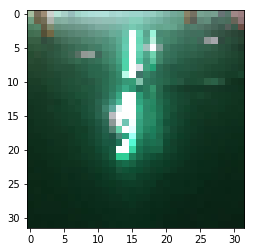

In [24]:
cancha = cv2.cvtColor(cv2.resize(cv2.imread('soccer.jpg'), (32, 32)), cv2.COLOR_BGR2RGB) / 255
plt.imshow(cancha)

In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(y_pred, feed_dict={x:[cancha], hold_prob:1.0}))
    pred = sess.run(tf.argmax(y_pred,1)[0], feed_dict={x:[cancha], hold_prob:1.0})
    p = sess.run(tf.cast(pred, tf.int32))
    print(predicted[p])
    

[[-0.58346283  0.12366138  3.6241825  -2.449131  ]]
office


In [38]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('models2/image_classifier.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./models2'))
    graph = tf.get_default_graph()
    for op in graph.get_operations():
        print(op.name)

INFO:tensorflow:Restoring parameters from ./models2/image_classifier.ckpt
input_x
Placeholder
hold_prob_dropout
truncated_normal/shape
truncated_normal/mean
truncated_normal/stddev
truncated_normal/TruncatedNormal
truncated_normal/mul
truncated_normal
Variable
Variable/Assign
Variable/read
Const
Variable_1
Variable_1/Assign
Variable_1/read
Conv2D
add
Relu
MaxPool
truncated_normal_1/shape
truncated_normal_1/mean
truncated_normal_1/stddev
truncated_normal_1/TruncatedNormal
truncated_normal_1/mul
truncated_normal_1
Variable_2
Variable_2/Assign
Variable_2/read
Const_1
Variable_3
Variable_3/Assign
Variable_3/read
Conv2D_1
add_1
Relu_1
MaxPool_1
Reshape/shape
Reshape
truncated_normal_2/shape
truncated_normal_2/mean
truncated_normal_2/stddev
truncated_normal_2/TruncatedNormal
truncated_normal_2/mul
truncated_normal_2
Variable_4
Variable_4/Assign
Variable_4/read
Const_2
Variable_5
Variable_5/Assign
Variable_5/read
MatMul
add_2
Relu_2
dropout/Shape
dropout/random_uniform/min
dropout/random_unif

Equal_51
Cast_52
Const_56
Mean_52
ArgMax_104/dimension
ArgMax_104
ArgMax_105/dimension
ArgMax_105
Equal_52
Cast_53
Const_57
Mean_53
ArgMax_106/dimension
ArgMax_106
ArgMax_107/dimension
ArgMax_107
Equal_53
Cast_54
Const_58
Mean_54
ArgMax_108/dimension
ArgMax_108
ArgMax_109/dimension
ArgMax_109
Equal_54
Cast_55
Const_59
Mean_55
ArgMax_110/dimension
ArgMax_110
ArgMax_111/dimension
ArgMax_111
Equal_55
Cast_56
Const_60
Mean_56
ArgMax_112/dimension
ArgMax_112
ArgMax_113/dimension
ArgMax_113
Equal_56
Cast_57
Const_61
Mean_57
ArgMax_114/dimension
ArgMax_114
ArgMax_115/dimension
ArgMax_115
Equal_57
Cast_58
Const_62
Mean_58
ArgMax_116/dimension
ArgMax_116
ArgMax_117/dimension
ArgMax_117
Equal_58
Cast_59
Const_63
Mean_59
ArgMax_118/dimension
ArgMax_118
ArgMax_119/dimension
ArgMax_119
Equal_59
Cast_60
Const_64
Mean_60
ArgMax_120/dimension
ArgMax_120
ArgMax_121/dimension
ArgMax_121
Equal_60
Cast_61
Const_65
Mean_61
ArgMax_122/dimension
ArgMax_122
ArgMax_123/dimension
ArgMax_123
Equal_61
Cast_62
Con

beta1_power/Assign
beta1_power/read
beta2_power/initial_value
beta2_power
beta2_power/Assign
beta2_power/read
Variable/Adam/Initializer/zeros
Variable/Adam
Variable/Adam/Assign
Variable/Adam/read
Variable/Adam_1/Initializer/zeros
Variable/Adam_1
Variable/Adam_1/Assign
Variable/Adam_1/read
Variable_1/Adam/Initializer/zeros
Variable_1/Adam
Variable_1/Adam/Assign
Variable_1/Adam/read
Variable_1/Adam_1/Initializer/zeros
Variable_1/Adam_1
Variable_1/Adam_1/Assign
Variable_1/Adam_1/read
Variable_2/Adam/Initializer/zeros
Variable_2/Adam
Variable_2/Adam/Assign
Variable_2/Adam/read
Variable_2/Adam_1/Initializer/zeros
Variable_2/Adam_1
Variable_2/Adam_1/Assign
Variable_2/Adam_1/read
Variable_3/Adam/Initializer/zeros
Variable_3/Adam
Variable_3/Adam/Assign
Variable_3/Adam/read
Variable_3/Adam_1/Initializer/zeros
Variable_3/Adam_1
Variable_3/Adam_1/Assign
Variable_3/Adam_1/read
Variable_4/Adam/Initializer/zeros
Variable_4/Adam
Variable_4/Adam/Assign
Variable_4/Adam/read
Variable_4/Adam_1/Initialize

Cast_38_1
Const_42_1
Mean_38_1
ArgMax_76/dimension_1
ArgMax_76_1
ArgMax_77/dimension_1
ArgMax_77_1
Equal_38_1
Cast_39_1
Const_43_1
Mean_39_1
ArgMax_78/dimension_1
ArgMax_78_1
ArgMax_79/dimension_1
ArgMax_79_1
Equal_39_1
Cast_40_1
Const_44_1
Mean_40_1
ArgMax_80/dimension_1
ArgMax_80_1
ArgMax_81/dimension_1
ArgMax_81_1
Equal_40_1
Cast_41_1
Const_45_1
Mean_41_1
ArgMax_82/dimension_1
ArgMax_82_1
ArgMax_83/dimension_1
ArgMax_83_1
Equal_41_1
Cast_42_1
Const_46_1
Mean_42_1
ArgMax_84/dimension_1
ArgMax_84_1
ArgMax_85/dimension_1
ArgMax_85_1
Equal_42_1
Cast_43_1
Const_47_1
Mean_43_1
ArgMax_86/dimension_1
ArgMax_86_1
ArgMax_87/dimension_1
ArgMax_87_1
Equal_43_1
Cast_44_1
Const_48_1
Mean_44_1
ArgMax_88/dimension_1
ArgMax_88_1
ArgMax_89/dimension_1
ArgMax_89_1
Equal_44_1
Cast_45_1
Const_49_1
Mean_45_1
ArgMax_90/dimension_1
ArgMax_90_1
ArgMax_91/dimension_1
ArgMax_91_1
Equal_45_1
Cast_46_1
Const_50_1
Mean_46_1
ArgMax_92/dimension_1
ArgMax_92_1
ArgMax_93/dimension_1
ArgMax_93_1
Equal_46_1
Cast_47_1
